In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.fft as fft
from iminuit import Minuit

# Initial conditions and functions

In [84]:
s_dim = 500
N = 15
radius = 10
step_size = 5
width = int(3 * radius)


bounds = (0 + 20 , s_dim - 20)
width_bounds = (0 + 1, width - 1)
diff = 1.0 

p_amount = int(N * 0.1)
step = [5, 10]
dev = 50

sl = int(width/2)
roi_params = [int(s_dim / 10), int(s_dim / 3)]

In [73]:
sample_pixel_size = 200 * 10e-6

pixelspace = s_dim/2                                                # in units of pixels
pixel_extent = [-pixelspace, pixelspace, -pixelspace, pixelspace]

realspace = (sample_pixel_size * (s_dim/2))                         # [currently m]
real_extent = [-realspace, realspace, -realspace, realspace]

recipspace = (2 * np.pi / realspace)                               # in units of 'a' [currently AA]
recip_extent = [-recipspace, recipspace, -recipspace, recipspace]

In [74]:
def p_locs(N, s_dim, min_distance):
    positions = []
    center = [(bounds[0] + bounds[1]) / 2, (bounds[0] + bounds[1]) / 2, 
              (width_bounds[0] + width_bounds[1]) / 2]  

    while len(positions) < N:
        # Generate new position with a normal distribution centered at the center
        new_pos = np.random.normal(loc=center, scale=dev, size=(3,))
        
        # Ensure new position is within bounds
        if ((bounds[0] + radius <= new_pos[0] <= bounds[1] - radius) and 
            (bounds[0] + radius <= new_pos[1] <= bounds[1] - radius) and 
            (width_bounds[0] + radius <= new_pos[2] <= width_bounds[1] - radius)):
            
            # Check distances from existing particles
            if len(positions) > 0:
                distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
                if np.all(distances >= min_distance):
                    positions.append(new_pos)
            else:
                positions.append(new_pos)

    return np.array(positions)

In [75]:
def p_locs1(N, dev, min_distance): #Generate the samples in matrix form from locations
    
    positions = []
    while len(positions) < N:
        new_pos_xy = np.random.uniform(bounds[0] + radius, bounds[1] - radius, size=(2,))
        new_pos_z = np.random.uniform(width_bounds[0] + radius, width_bounds[1] - radius, size = (1,))
        new_pos = np.hstack((new_pos_xy, new_pos_z))
        
        # Check distances from existing particles
        if len(positions) > 0:
            distances = np.linalg.norm(new_pos - np.array(positions), axis=1)
            if np.all(distances >= min_distance):
                positions.append(new_pos)
        else:
            positions.append(new_pos)

    return np.array(positions)


def sample(locs): #Places the particle's location in a matrix - creating the sample matrix
    sample = np.zeros((s_dim, s_dim, width))
    for i in range(len(locs)):
        xx, yy, zz = np.meshgrid(range(s_dim), range(s_dim), range(width))
        dist_squared = (xx - locs[:,0][i]) ** 2 + (yy - locs[:,1][i] ) ** 2 + (zz - locs[:,2][i]) ** 2
        sample[dist_squared <= radius**2] = 1
    
    return sample

In [76]:
def brown_motion(ip, step, diff, bounds, width_bounds, p_amount):
    # Set up
    old_positions = np.copy(ip)
    new_positions = np.copy(ip)  
    
    # Moving x amount of particles
    parts = np.random.randint(0, len(ip), p_amount)  # which particles to move

    for i in range(len(parts)):
        step_size = np.random.randint(step[0], step[1], 1)  # Step size of particle
        p_step = np.random.normal(scale = np.sqrt(2 * diff * step_size), size=3)  # Change coordinate
        new_positions[parts[i]] = ip[parts[i]] + p_step
            
        # Boundary conditions - periodic
        for j in range(2):  # Loop over x, y dimensions
            if new_positions[parts[i]][j] + radius > bounds[1]:
                new_positions[parts[i]][j] = bounds[0] + radius
            elif new_positions[parts[i]][j] - radius < bounds[0]:
                new_positions[parts[i]][j] = bounds[1] - radius
        
        # Boundary conditions for depth
        if new_positions[parts[i]][2] + 2 * radius > width_bounds[1]:
            new_positions[parts[i]][2] = width_bounds[1] - radius
        elif new_positions[parts[i]][2] - radius < width_bounds[0]:
            new_positions[parts[i]][2] = width_bounds[0] + radius  
        

    # Collision avoidance, if their trajectories collide - they go back to their old position
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                new_positions[i] = old_positions[i]
                new_positions[j] = old_positions[j]
                
    # Collision avoidance in 3D
    for i in range(len(new_positions)):
        for j in range(i + 1, len(new_positions)):
            dist = np.linalg.norm(new_positions[i] - new_positions[j])
            if dist == 0:
                dist = 2 * radius + 1
            elif dist < 2 * radius:
                # Calculate the direction of collision
                direction = (new_positions[j] - new_positions[i]) / dist
                # Move the particles back along the collision direction
                new_positions[i] -= direction * (2 * radius - dist) / 2
                new_positions[j] += direction * (2 * radius - dist) / 2
    
    
        return new_positions, old_positions


In [77]:
def bm3(ip, n_size, diff, bounds, width_bounds): #3D Brownian motion function 
    positions = []
    old_positions = []
    
    for i in range(len(ip)):
        step = np.random.normal(scale=np.sqrt(2 * diff * n_size), size=3)  # One step only
        new_pos = ip[i] + step
        old_pos = ip[i]

        # Boundary conditions - periodic
        for j in range(2):  # Loop over x, y dimensions
            if new_pos[j] + radius > bounds[1]:
                new_pos[j] = bounds[0] + radius
            elif new_pos[j] - radius < bounds[0]:
                new_pos[j] = bounds[1] - radius
        
        # Boundary conditions for width
        if new_pos[2] + radius > width_bounds[1]:
            new_pos[2] = width_bounds[1] - radius
        elif new_pos[2] - radius < width_bounds[0]:
            new_pos[2] = width_bounds[0] + radius
        
        positions.append(new_pos)
        old_positions.append(old_pos)

    # Collision avoidance
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):  # Avoid redundant calculations by starting from i+1
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < 2 * radius:
                positions[i] = old_positions[i]  # Reset position

    return positions, old_positions

# Creating initial sample

In [85]:
locs = p_locs(N, s_dim, radius)

In [86]:
np.shape(locs)

(15, 3)

In [87]:
samp = sample(locs)

In [88]:
np.shape(samp)

(500, 500, 30)

In [89]:
locs

array([[230.98668765, 237.7245063 ,  11.61650411],
       [193.52066094, 202.85594869,  15.98250577],
       [309.76879035, 200.20355441,  11.49198445],
       [254.15901677, 265.51970631,  17.55058695],
       [243.66638733, 298.55250861,  12.68781716],
       [162.93539475, 267.08818789,  18.06635483],
       [317.8084217 , 303.69010092,  14.29256744],
       [249.02379564, 285.14512968,  14.41323455],
       [242.04291507, 198.88223511,  16.06674669],
       [246.18340691, 154.60266505,  14.97655206],
       [236.13979305, 280.65395311,  12.63794026],
       [164.87333666, 240.51616081,  16.48511821],
       [265.35171495, 253.7080236 ,  11.23778064],
       [246.51862168, 227.36491006,  15.57800526],
       [264.90378866, 243.24747217,  18.91693698]])

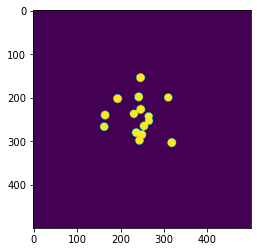

In [90]:
plt.imshow(samp[:,:,sl])

# Moving the particles (Brownian motion)

In [91]:
new_samp, old_samp = brown_motion(locs, step, diff, bounds, width_bounds, p_amount)

In [92]:
brown1 = sample(np.array(new_samp))

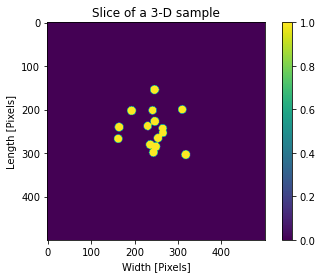

In [93]:
plt.figure(1)
plt.imshow(brown1[:,:,sl])
plt.xlabel('Width [Pixels]')
plt.ylabel('Length [Pixels]')
plt.title('Slice of a 3-D sample')
plt.colorbar()
#plt.savefig('pics/3dsamp.png', dpi = 300)

In [94]:
brown1.shape

(500, 500, 30)

In [18]:
n = 0
il = np.copy(locs)
nl = []
while n < 50:
    new_l, old_l = brown_motion(il, step, diff, bounds, width_bounds, p_amount)
    nn = np.vstack(new_l)
    nl.append(nn)
    il = nn
    n += 1

In [19]:
%%time
frames = []
for i in range(len(nl)):
    fr = sample(nl[i])
    frames.append(fr)
    print('frame {}'.format(i))

frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9
frame 10
frame 11
frame 12
frame 13
frame 14
frame 15
frame 16
frame 17
frame 18
frame 19
frame 20
frame 21
frame 22
frame 23
frame 24
frame 25
frame 26
frame 27
frame 28
frame 29
frame 30
frame 31
frame 32
frame 33
frame 34
frame 35
frame 36
frame 37
frame 38
frame 39
frame 40
frame 41
frame 42
frame 43
frame 44
frame 45
frame 46
frame 47
frame 48
frame 49
CPU times: user 1min 2s, sys: 30 s, total: 1min 32s
Wall time: 1min 32s


In [20]:
np.array(frames)[0,:,:,sl].shape

(500, 500)

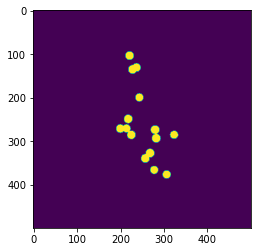

In [21]:
plt.imshow(np.array(frames)[1,:,:,sl])

In [22]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#num_frames = len(frames)
#
#fig, ax = plt.subplots()
#im = ax.imshow(np.array(frames)[0,:,:,13], cmap='viridis')
#
#def update(frame):
#    im.set_array(np.array(frames)[frame,:,:,13]) 
#    return [im]
#
#ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=True)
#HTML(ani.to_jshtml())

# Simulate beam

In [23]:
pixel_size = 0.2# Pixel size
sample_detector_distance = 8e6  # Sample-detector distance 
wavelength = 0.99  # Wavelength 

#Vector components
ny, nx, nz = samp.shape  
qy, qx, qz = np.meshgrid(np.fft.fftfreq(ny, pixel_size), 
                         np.fft.fftfreq(nx, pixel_size),
                         np.fft.fftfreq(nz, pixel_size), indexing='ij')


q = np.sqrt(qx ** 2 + qy ** 2 + qz ** 2)

#Calculate intensity
sc_intens = np.abs(fft.fftn(samp)) ** 2  
sc_intens_q = np.fft.fftshift(fft.fftn(samp))  

#Beam profile
beam_profile = np.exp(- (q ** 2) / (4 * (1 / wavelength) ** 2))

#Beam sample interaction
intens = fft.fftshift(fft.ifftn(fft.fftn(sc_intens) * fft.fftn(beam_profile)))
intens_q = fft.fftshift(fft.ifftn(fft.fftn(sc_intens_q) * fft.fftn(beam_profile)))

 #Speckle patterns
spek = np.abs(intens) ** 2  
speq = np.abs(intens_q) ** 2  


In [24]:
spek[:,:,sl].shape

(500, 500)

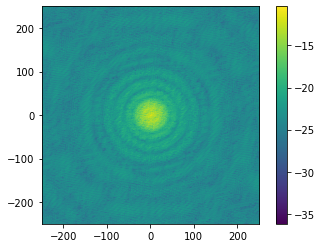

In [25]:
plt.imshow(np.log(speq[:,:,sl]), extent = pixel_extent)
plt.colorbar()

Works for one frame, doing it fall all the frames

In [26]:
def specks(frames):
    spekls = []
    speqls = []
    for i in range(len(frames)):
        samp = frames[i]
        
        ny, nx, nz = samp.shape  
        qy, qx, qz = np.meshgrid(np.fft.fftfreq(ny, pixel_size), 
                         np.fft.fftfreq(nx, pixel_size),
                         np.fft.fftfreq(nz, pixel_size), indexing='ij')


        q = np.sqrt(qx ** 2 + qy ** 2 + qz ** 2)

        
        sc_intens = np.abs(fft.fftn(samp)) ** 2  
        sc_intens_q = np.fft.fftshift(fft.fftn(samp))  

       
        beam_profile = np.exp(- (q ** 2) / (4 * (1 / wavelength) ** 2))

        
        intens = fft.fftshift(fft.ifftn(fft.fftn(sc_intens) * fft.fftn(beam_profile)))
        intens_q = fft.fftshift(fft.ifftn(fft.fftn(sc_intens_q) * fft.fftn(beam_profile)))

        
        spek = np.abs(intens) ** 2  
        speq = np.abs(intens_q) ** 2  
        
        spekls.append(spek)
        speqls.append(speq)
        
    return spekls, speqls

In [27]:
%%time
spk, spq = specks(frames)

spqls = np.array(spq)

CPU times: user 2min 47s, sys: 10.8 s, total: 2min 58s
Wall time: 2min 58s


In [28]:
np.shape((spqls)[1,:,:,sl])

(500, 500)

Movie

In [29]:
slices = np.linspace(sl-1,sl+1,3)

thick = []
for i in range(len(slices)):
    spq = spqls[:,:,:,int(slices[i])]
    thick.append(spq)
thick_a = np.mean(thick, axis=0) #averaged the 11 thickness into one size


avg_mat1 = np.mean(spqls, axis = (3))

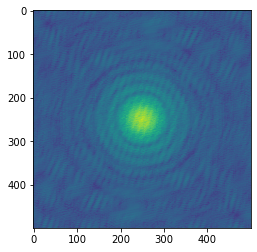

In [30]:
plt.imshow(np.log(thick_a[10]))

In [31]:
len(thick_a)

50

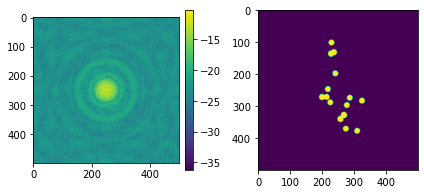

In [32]:
num_frames = len(spq)
#num_frames = 25

constant = np.zeros(np.shape((spqls)[1,:,:,sl])) + 1e-6

fig, (ax1, ax2) = plt.subplots(1,2, sharey = False)
im1 = ax1.imshow((np.log(spqls[0,:,:,sl])), cmap='viridis')

#ax1.set_xlim(lims)
#ax1.set_ylim(lims)

im2 = ax2.imshow(np.array(frames)[0,:,:,sl], cmap = 'viridis')

fig.colorbar(im1, ax = ax1, fraction = 0.05, pad = 0.04)
fig.tight_layout()
def update(frame):
    im1.set_array((np.log((spqls[frame,:,:,sl]))))
    im2.set_array(np.array(frames)[frame,:,:,sl])
    return [im1, im2]

ani = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
HTML(ani.to_jshtml())

In [33]:
avg_mat1.shape

(50, 500, 500)

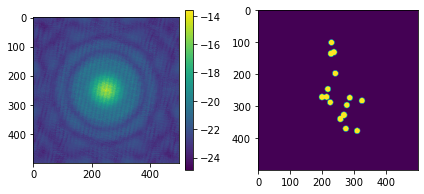

In [34]:
num_frames = len(thick_a)

constant = np.zeros(np.shape((avg_mat1[1]))) + 1e-6

fig, (ax1, ax2) = plt.subplots(1,2, sharey = False)
im1 = ax1.imshow((np.log(avg_mat1[0])), cmap='viridis')

#ax1.set_xlim(lims)
#ax1.set_ylim(lims)

im2 = ax2.imshow(np.array(frames)[0,:,:,sl], cmap = 'viridis')

fig.colorbar(im1, ax = ax1, fraction = 0.05, pad = 0.04)
fig.tight_layout()
def update(frame):
    im1.set_array((np.log((avg_mat1[frame]))))
    im2.set_array(np.array(frames)[frame,:,:,sl])
    return [im1, im2]

ani = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
HTML(ani.to_jshtml())

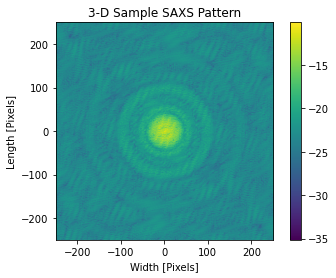

In [35]:
plt.figure()
plt.imshow((np.log(spqls[10,:,:,sl])), extent = pixel_extent)
plt.xlabel('Width [Pixels]')
plt.ylabel('Length [Pixels]')
plt.title('3-D Sample SAXS Pattern')
plt.colorbar()
#plt.savefig('pics/3dsaxs.png', dpi = 300)

Text(0.5, 1.0, 'Averaged 3-D Sample SAXS Pattern')

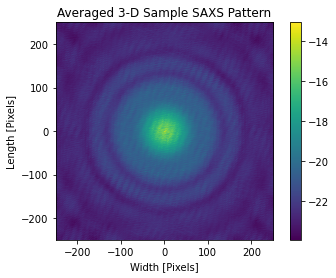

In [36]:
plt.figure()
plt.imshow((np.log(np.mean(avg_mat1,axis = 0))), extent = pixel_extent)
plt.colorbar()
plt.xlabel('Width [Pixels]')
plt.ylabel('Length [Pixels]')
plt.title('Averaged 3-D Sample SAXS Pattern')
#plt.savefig('avg3dsaxs.png', dpi = 300)

Make the slice thicker

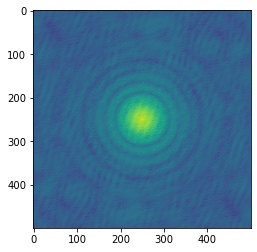

In [37]:
plt.imshow(np.log(thick_a[4,:,:]))

In [38]:
spqls.shape

(50, 500, 500, 30)

Azimuthal

In [39]:
import math as m
image = ((spqls[1,:,:,sl]))

center = (s_dim/2, s_dim/2)
d = m.floor(np.sqrt(center[0] ** 2 + center[1] ** 2))

centered = np.meshgrid(np.arange(s_dim) - center[0], np.arange(s_dim) - center[1])
rad = np.sqrt((centered[0] ** 2) + (centered[1] ** 2))

r = np.linspace(1, int(center[0]) + 1, int(center[0]))

d = lambda r : image[(rad >= r - 0.1) & (rad < r + 0.1)].mean()

In [40]:
len(thick_a)

50

In [41]:
mean_d = np.vectorize(d)(r)
p_az = np.linspace(0, 250, len(spqls[1,:,:,sl]))

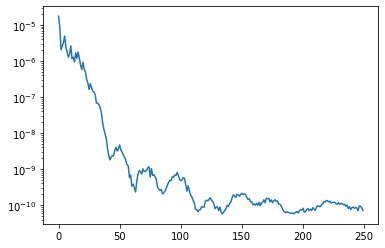

In [42]:
plt.plot((mean_d))
plt.yscale('log')
#plt.xscale('log')

ROI and TTCF

In [43]:
#roi_c = [80, 100]

x, y = np.ogrid[:s_dim, :s_dim]
c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
mask = (c_dist <= roi_params[1]) & (c_dist >= roi_params[0])

c_roi = np.zeros_like(spqls[0,:,:,sl])
c_roi[mask] = spqls[0,:,:,sl][mask]

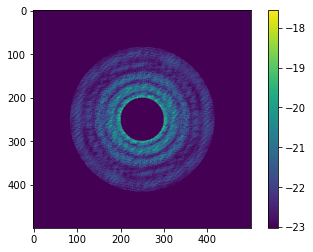

In [44]:
plt.imshow(np.log(c_roi + 1e-10)) 
plt.colorbar()

In [45]:
def roi(upper, lower, speqs):
    roi = [upper, lower]
    
    x, y = np.ogrid[:s_dim, :s_dim]
    c_dist = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    mask = (c_dist <= roi[1]) & (c_dist >= roi[0])
    
    rois = []

    for i in range(len(speqs)):
        mat = np.zeros_like(speqs[i])
        mat[mask] = speqs[i][mask]
        rois.append(mat[mask])
        
    return np.array(rois)

In [46]:
roi_c = roi(roi_params[0],roi_params[1],spqls[:,:,:,sl])
roi_a = roi(roi_params[0], roi_params[1], avg_mat1)

In [47]:
roi_c.shape

(50, 78700)

In [48]:
np.shape(spqls)

(50, 500, 500, 30)

In [49]:
ttcf = np.matmul(roi_c, roi_c.T)
ttcf_norm = ttcf / ttcf.max()

In [50]:
ttcf_a = np.matmul(roi_a, roi_a.T)
ttcf_norm_a = ttcf_a / ttcf.max()

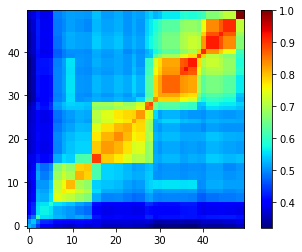

In [58]:
plt.imshow(ttcf/ ttcf.max(), origin = 'lower', cmap = 'jet') 
plt.colorbar()

In [59]:
def get_cf(darr,skip_last=0):
    return np.array([np.nanmean(np.diagonal(darr,offset=i)) for i in range(1,len(darr)-skip_last)])

def e_decay(dt,Gm,beta,off):
    g1 = np.exp(-Gm*dt)
    g2 = beta*g1**2+off
    return g2

g2 = get_cf(ttcf/ttcf.max())
t_steps = np.linspace(0, len(g2), len(g2))

y_err = np.std(g2)

In [60]:
def chi2(Gm,beta,off):
    y_exp = e_decay(t_steps,Gm,beta,off)
    chi2 = np.sum(((g2 - y_exp) / y_err)**2)
    return chi2

In [61]:
fit = Minuit(chi2, beta = g2[0], Gm = 5, off = min(g2))
fit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.761                      │              Nfcn = 142              │
│ EDM = 7.71e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Gm   │   0.035   │   0.018   │            │            │         │         │       │
│ 1 │ beta │   0.36    │   0.05    │            │            │         │         │       │
│ 2 │ off  │   0.40    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────┐
│      │       Gm     beta      off │
├──────┼────────────────────────────┤
│   Gm │ 0.000316  0.01e-3  0.79e-3 │
│ beta │  0.01e-3  0.00273  -0.0008 │
│  off │  0.79e-3  -0.0008  0.00238 │
└──────┴────────────────────────────┘

In [62]:
Gm, beta, off = fit.values

curve_fit = e_decay(t_steps, Gm, beta, off)
chi2_val = np.round(fit.fval, 2)

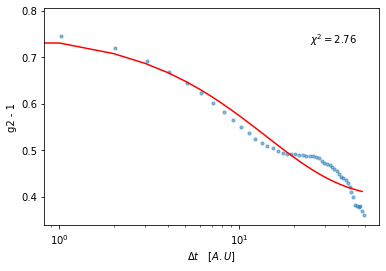

In [63]:
plt.scatter(t_steps, get_cf(ttcf/ttcf.max()), s = 10, alpha = 0.5)
plt.plot(curve_fit, color = 'r')
plt.ylabel('g2 - 1')
plt.xlabel(r'$\Delta t \quad [A.U]$')
plt.xscale('log')
plt.text(x = len(curve_fit) - len(curve_fit)/2, y = curve_fit[1],
         s = r'$\chi^{} = {}$'.format(2,chi2_val));

In [64]:
fit.fval

2.7607952484401936

In [65]:
fit_params = ['Gm: Decay rate','beta: Contrast','off: Offset']
for i in range(len(fit.values)):
    print(fit_params[i],np.round(fit.values[i],4))

Gm: Decay rate 0.0349
beta: Contrast 0.355
off: Offset 0.3998
